theta:  [ 1.33962892 -0.09140241 -0.56483985  0.41516721  0.04654069]
Linear Model Train performance (MSE): 	0.68
Linear Model Test performance (MSE): 	0.83
Mean squared error:  0.8334197158646833
Polynomial Model Train performance (MSE): 	0.24
Polynomial Model Test performance (MSE): 	0.31
Null Hypothesis H0: The two models have the same variance
Reject the null hypothesis and select the Polynomial model, which possesses the smaller variance
Random Forest Test performance (MSE): 0.02283
Random Forest Train performance(MSE): 0.00327
Everything useful


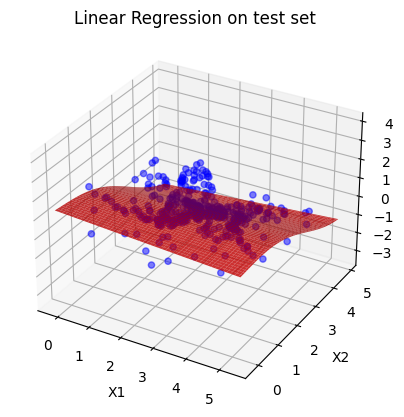

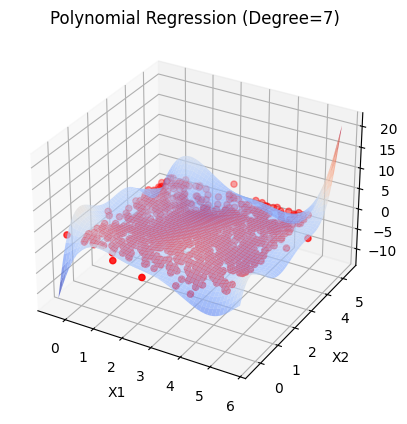

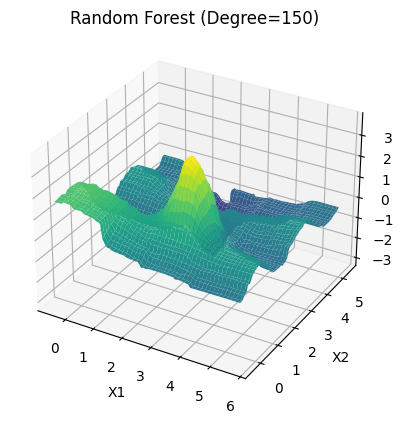

In [ ]:
# Import libraries
import io
import requests
import numpy as np
from sklearn.metrics import mean_squared_error          # Function to calculate the Mean Squared Error (our performance measure)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt # Library for plotting
from sklearn.linear_model import LinearRegression       # Linear Regression model
import joblib
from matplotlib import cm

# Load data
url = 'https://drive.switch.ch/index.php/s/TeDwnbYsBKRuJjv/download'
response = requests.get(url)
data = np.load(io.BytesIO(response.content))

# Alternatively yo can load the data from file
# data_path = '../data/data.npz' # path to the .npz file storing the data
# data = np.load(data_path)

# x is a Numpy array of shape (n_samples, n_features) with the inputs
x = data.f.x # (2000, 2)
y = data.f.y # (2000, )
# subdivide the data in x_train and x_test, random_state=1 for reproducibility (always the same shuffle)
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.25, random_state=1)

# T1

# Compact form; X_test refers as the training set compact form
X_train = np.column_stack((np.ones(len(x_train)), x_train[:,0], x_train[:,1], np.sin(x_train[:,1]), x_train[:,0]*x_train[:,1]))
X_test = np.column_stack((np.ones(len(x_test)), x_test[:,0], x_test[:,1], np.sin(x_test[:,1]), x_test[:,0]*x_test[:,1]))

#### method 2
# init the model
lr = LinearRegression(fit_intercept=False)
# estimate parameters
lr.fit(X_train, y_train)
theta_hat = lr.coef_
# another way to estimate parameters
# Solve the linear system with np.linalg.solve()
theta_hat2 = np.linalg.solve(a=X_train.T.dot(X_train), b=X_train.T.dot(y_train))   # Solves ax = b with respect to x
# save the model
# joblib.dump(lr, 'linear_regression.pickle')
####

##############

print("theta: ", theta_hat)
# compute train performance
train_predict = lr.predict(X_train)
# train_predict = lr.predict(x_train)
train_performance = mean_squared_error(train_predict, y_train)
print(f"Linear Model Train performance (MSE): \t{train_performance:.2f}")

# compute test performance
test_pred = lr.predict(X_test)
test_performance = mean_squared_error(test_pred, y_test)
print(f"Linear Model Test performance (MSE): \t{test_performance:.2f}")
print("Mean squared error: ", test_performance)

# T2
from sklearn.preprocessing import PolynomialFeatures

degree = 7
# Create polynomial features
poly = PolynomialFeatures(degree=degree)
x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.fit_transform(x_test)

# Fit the model to the training data
model = LinearRegression()
model.fit(x_train_poly, y_train)
# joblib.dump(model, 'polynomial_regression.pickle')

# Predict on the train data
y_pred_train = model.predict(x_train_poly)
poly_train_performance = mean_squared_error(y_pred_train, y_train)
print(f"Polynomial Model Train performance (MSE): \t{poly_train_performance:.2f}")
# Predict on the testing data
y_pred_test = model.predict(x_test_poly)
poly_test_performance = mean_squared_error(y_pred_test, y_test)
print(f"Polynomial Model Test performance (MSE): \t{poly_test_performance:.2f}")

# Calculate squared residuals for both models
linear_residuals = np.square(y_train - train_predict)
poly_residuals = np.square(y_train - y_pred_train)
# Calculate mean and variance for both models
linear_residual_mean = np.sum(linear_residuals) / len(linear_residuals) # 1
polynomial_residual_mean = np.sum(poly_residuals) / len(poly_residuals) # 2
linear_residual_var = np.sum(np.square(linear_residuals - linear_residual_mean)) / (len(linear_residuals) - 1) # 11
polynomial_residual_var = np.sum(np.square(poly_residuals - polynomial_residual_mean)) / (len(poly_residuals) - 1) # 22

# Compute the t test
print("Null Hypothesis H0: The two models have the same variance")
T = (linear_residual_mean - polynomial_residual_mean) / np.sqrt((linear_residual_var / len(linear_residuals)) + (polynomial_residual_var / len(poly_residuals)))
# assume T is normally distributed N(0,1):
# if T is outside the confidence interval 95% (-1.96, 1.96), reject the null hypothesis
alpha = 0.05
# degrees of freedom
df = len(linear_residuals) + len(poly_residuals) - 2
# critical value
from scipy.stats import t
critical_value = t.ppf(1.0 - alpha/2, df) # check if is atually 1.96

# Check if T is outside the confidence interval
if  -critical_value > T or critical_value < T:
    # choose model with smaller variance
    if linear_residual_var < polynomial_residual_var:
        selected_model = "Linear"
    else:
        selected_model = "Polynomial"
    print(f"Reject the null hypothesis and select the {selected_model} model, which possesses the smaller variance")
else:
    print(f"Fail to reject the null hypothesis")

# T3 (Bonus)

# method RandomForest
from sklearn.ensemble import RandomForestRegressor
# random_state=1 for reproducibility (always the same shuffle)
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
X_train = np.column_stack((np.ones(len(x_train)), x_train[:,0], x_train[:,1], np.sin(x_train[:,1]), x_train[:,0]*x_train[:,1]))
X_val = np.column_stack((np.ones(len(x_val)), x_val[:,0], x_val[:,1], np.sin(x_val[:,1]), x_val[:,0]*x_val[:,1]))
X_test = np.column_stack((np.ones(len(x_test)), x_test[:,0], x_test[:,1], np.sin(x_test[:,1]), x_test[:,0]*x_test[:,1]))
# Create a Random Forest regressor with 3000 trees
trees = 150
rf = RandomForestRegressor(n_estimators=trees)
# Fit the model to the training data
rf.fit(X_train, y_train)
# save model
# joblib.dump(rf, 'RandomForestRegressor.pickle')
# Predict on the whole dataset with RandomForest model
# Make predictions on the test data
y_test_pred = rf.predict(X_test)
# Evaluate the model performance using the mean squared error
mse = mean_squared_error(y_test_pred, y_test)
print("Random Forest Test performance (MSE): {:.5f}".format(mse))
# Make predictions on the train data
y_train_pred = rf.predict(X_train)
# Evaluate the model performance using the mean squared error
mse = mean_squared_error(y_train_pred, y_train)
print("Random Forest Train performance(MSE): {:.5f}".format(mse))

print("Everything useful")
# linear regression test set plot
fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection='3d')
# Plot the data points
ax1.scatter(x_test[:,0], x_test[:,1], y_test, c='blue', marker='o', alpha=0.5)
# Set axis labels
ax1.set_xlabel('X1')
ax1.set_ylabel('X2')
ax1.set_title('Linear Regression on test set')
ax1.set_zlabel('Y')
# plot the model as a surface
x1 = np.linspace(x_test[:,0].min(), x_test[:,0].max(), 100)
x2 = np.linspace(x_test[:,1].min(), x_test[:,1].max(), 100)
x1, x2 = np.meshgrid(x1, x2)
# y_hat1 = linear_function([x11, x22], theta_hat)
X_grid = np.column_stack((x1.ravel(), x2.ravel(), np.sin(x2.ravel()), (x1*x2).ravel()))
X_grid = np.c_[np.ones(X_grid.shape[0]), X_grid]
y_hat = lr.predict(X_grid)
y_hat1 = y_hat.reshape(x1.shape)
ax1.plot_surface(x1, x2, y_hat1, color='red', alpha=0.8)
plt.show()

# Polynomial plot
# Create a meshgrid for plotting the surface
x1_p, x2_p = np.meshgrid(np.linspace(x_train[:,0].min(), x_train[:,0].max(), 100),
                     np.linspace(x_train[:,1].min(), x_train[:,1].max(), 100))
x1_poly = x1_p.reshape(-1, 1)
x2_poly = x2_p.reshape(-1, 1)
x_mesh_poly = poly.fit_transform(np.hstack([x1_poly, x2_poly]))

# Evaluate the model on the meshgrid
y_mesh = model.predict(x_mesh_poly)
y_mesh = y_mesh.reshape(x1_p.shape)

# Create the 3D plot
fig2 = plt.figure()
axP = fig2.add_subplot(111, projection='3d')
axP.scatter(x_train[:, 0], x_train[:, 1], y_train, color='red', label='Training data')
axP.plot_surface(x1_p, x2_p, y_mesh, cmap=cm.coolwarm, alpha=0.7) # , color='red'
axP.set_xlabel('X1')
axP.set_ylabel('X2')
axP.set_zlabel('Y')
axP.set_title('Polynomial Regression (Degree={})'.format(degree))
plt.show()

# plot trained RandomForest model
# Create a mesh grid of points spanning the range of the input features
x1, x2 = np.meshgrid(np.linspace(x_train[:,0].min(), x_train[:,0].max(), 100),
                     np.linspace(x_train[:,1].min(), x_train[:,1].max(), 100))
X_grid = np.column_stack((x1.ravel(), x2.ravel(), np.sin(x2.ravel()), (x1*x2).ravel()))
X_grid = np.c_[np.ones(X_grid.shape[0]), X_grid]
# Use the trained model to make predictions on the mesh grid
y_grid = rf.predict(X_grid)
# Reshape the predicted values to match the shape of the mesh grid
y_grid = y_grid.reshape(x1.shape)
# Plot the surface of the predicted values
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x1, x2, y_grid, cmap='viridis')
ax.set_title('Random Forest (Degree={})'.format(trees))
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [ ]:
# Import libraries
import joblib
import io
import requests
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


def evaluate_predictions(y_true, y_pred):
    """
    Evaluates the mean squared error between the values in y_true and the values
    in y_pred.
    ### YOU CAN NOT EDIT THIS FUNCTION ###
    :param y_true: Numpy array, the true target values from the test set;
    :param y_pred: Numpy array, the values predicted by your model.
    :return: float, the mean squared error between the two arrays.
    """
    assert y_true.shape == y_pred.shape
    return ((y_true - y_pred) ** 2).mean()


def load_model(filename):
    """
    Loads a Scikit-learn model saved with joblib.dump.
    This is just an example, you can write your own function to load the model.
    Some examples can be found in src/utils.py.
    :param filename: string, path to the file storing the model.
    :return: the model.
    """
    model = joblib.load(filename)

    return model

# Load the data
# This will be replaced with our private test data when grading the assignment

# Load data from url
url = 'https://drive.switch.ch/index.php/s/TeDwnbYsBKRuJjv/download'
response = requests.get(url)
data = np.load(io.BytesIO(response.content))

# Alternatively yo can load the data from file
# data_path = '../data/data.npz'
# data = np.load(data_path)

# x is a Numpy array of shape (n_samples, n_features) with the inputs
x = data.f.x
# y is a Numpy array of shape (n_samples, ) with the targets
y = data.f.y
# subdivide the data in x_train and x_test data with train_test_split()
x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=False, test_size=0.25)
# Change input
X_train = np.column_stack((np.ones(len(x_train)), x_train[:,0], x_train[:,1], np.sin(x_train[:,1]), x_train[:,0]*x_train[:,1]))
X_test = np.column_stack((np.ones(len(x_test)), x_test[:,0], x_test[:,1], np.sin(x_test[:,1]), x_test[:,0]*x_test[:,1]))
X = np.column_stack((np.ones(len(x)), x[:,0], x[:,1], np.sin(x[:,1]), x[:,0]*x[:,1]))
# Load the linear model
linear_regression_path = './linear_regression.pickle'
linear_regression = load_model(linear_regression_path)
# Load the polynomial model
polynomial_regression_path = './polynomial_regression.pickle'
polynomial_regression = load_model(polynomial_regression_path)
# Load the baseline model
baseline_model_path = './baseline_model.pickle'
baseline_model = load_model(baseline_model_path)
# Load the RandomForest model
RandomForestRegressor_path = './RandomForestRegressor.pickle'
RandomForestRegressor = load_model(RandomForestRegressor_path)
# Predict on the whole dataset with linear model
y_pred = linear_regression.predict(X)
mse = evaluate_predictions(y_pred, y)
print(f'Linear MSE on whole dataset: {mse}')
# Predict on the whole dataset with polynomial model
poly = PolynomialFeatures(degree=7)
x_poly = poly.fit_transform(x) # polynomial_regression
y_pred = polynomial_regression.predict(x_poly) #!!!
mse = evaluate_predictions(y_pred, y)
print(f'Polynomial MSE on whole dataset: {mse}')
# Predict on the whole dataset with RandomForest model
# Make predictions on the whole data
y_train_pred = RandomForestRegressor.predict(X)
# Evaluate the model performance using the mean squared error
mse = evaluate_predictions(y_train_pred, y)
print(f"Random Forest MSE on whole dataset: {mse}")
# Predict on the whole dataset with baseline model
y_pred = baseline_model.predict(X)
mse = evaluate_predictions(y_pred, y)
print(f'Baseline MSE on whole dataset: {mse}')

############################################################################
# STOP EDITABLE SECTION: do not modify anything below this point.
############################################################################

# Evaluate the prediction using MSE
mse = evaluate_predictions(y_pred, y)
print(f'\nMSE on whole dataset: {mse}')

# NOTE: NOW THIS CELL IS NOT WORKING SINCE YOU NEED TO CHANGE THE INPUT.
# DO IT AND EVERYTHING RUNS SMOOTH


Linear MSE on whole dataset: 0.7167335238440314
Polynomial MSE on whole dataset: 0.25649160075396094
Random Forest MSE on whole dataset: 0.011398067362211248
Baseline MSE on whole dataset: 0.022251897715738274

MSE on whole dataset: 0.022251897715738274
